In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from shapely.geometry import Polygon
from skimage.io import imread as skimread
from shapely import wkt
from companion_functions import (
    plot_polygons
)

In [2]:
polygons_xenium = '/srv/gstore/projects/p37785/Visium_HD_HLC_pXPE2_Xseg/nuclei_df.csv'

polygons_enact = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cells_df.csv'

wsi_image_path = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/tmap/wsi.tif'

In [5]:

# Load the Visium full resolution image
wsi_image = skimread(wsi_image_path)


In [6]:
# Filter polygons to those that overlap the zoomed region
def polygon_in_crop(polygon, x_min, x_max, y_min, y_max):
    # polygon: (N,) array of interleaved x and y coordinates
    xs = polygon[::2]  # x coordinates are at even indices
    ys = polygon[1::2] # y coordinates are at odd indices
    return (
        (xs >= x_min).any() and (xs < x_max).any() and
        (ys >= y_min).any() and (ys < y_max).any()
    )

# Shift polygons so they match the crop region
def shift_polygon(polygon, x_min, y_min):
    shifted_polygon = polygon.copy()
    shifted_polygon[::2] -= x_min  # Subtract x_min from x coordinates
    shifted_polygon[1::2] -= y_min # Subtract y_min from y coordinates
    return shifted_polygon

In [7]:
xenium_cell_polygons = pd.read_csv(polygons_xenium)
enact_cell_polygons = pd.read_csv(polygons_enact)

xenium_cell_polygons = xenium_cell_polygons.dropna(subset=['geometry'])
enact_cell_polygons = enact_cell_polygons.dropna(subset=['geometry'])

xenium_cell_polygons["parsed_geometry"] = xenium_cell_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
xenium_cell_polygons["parsed_coordinates"] = xenium_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)

enact_cell_polygons["parsed_geometry"] = enact_cell_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
enact_cell_polygons["parsed_coordinates"] = enact_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)


xenium_polygons = xenium_cell_polygons["parsed_coordinates"].to_numpy()

enact_polygons = enact_cell_polygons["parsed_coordinates"].to_numpy()

# Compute centers for Xenium polygons
xenium_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in xenium_polygons
])

# Compute centers for ENACT polygons
enact_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in enact_polygons
])

In [8]:
crop_size = 1000
x_min, y_min = 2000, 2000  # Starting coordinates for the crop
x_max,y_max = x_min + crop_size, y_min + crop_size  # Ending coordinates for the crop

In [15]:

xenium_crop_polygons_demean = [
    shift_polygon(poly, *center).reshape(-1, 2)
    for poly, center in zip(xenium_polygons, xenium_centers)
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]
enact_crop_polygons_demean = [
    shift_polygon(poly, *center).reshape(-1, 2)
    for poly, center in zip(enact_polygons, enact_centers)
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]

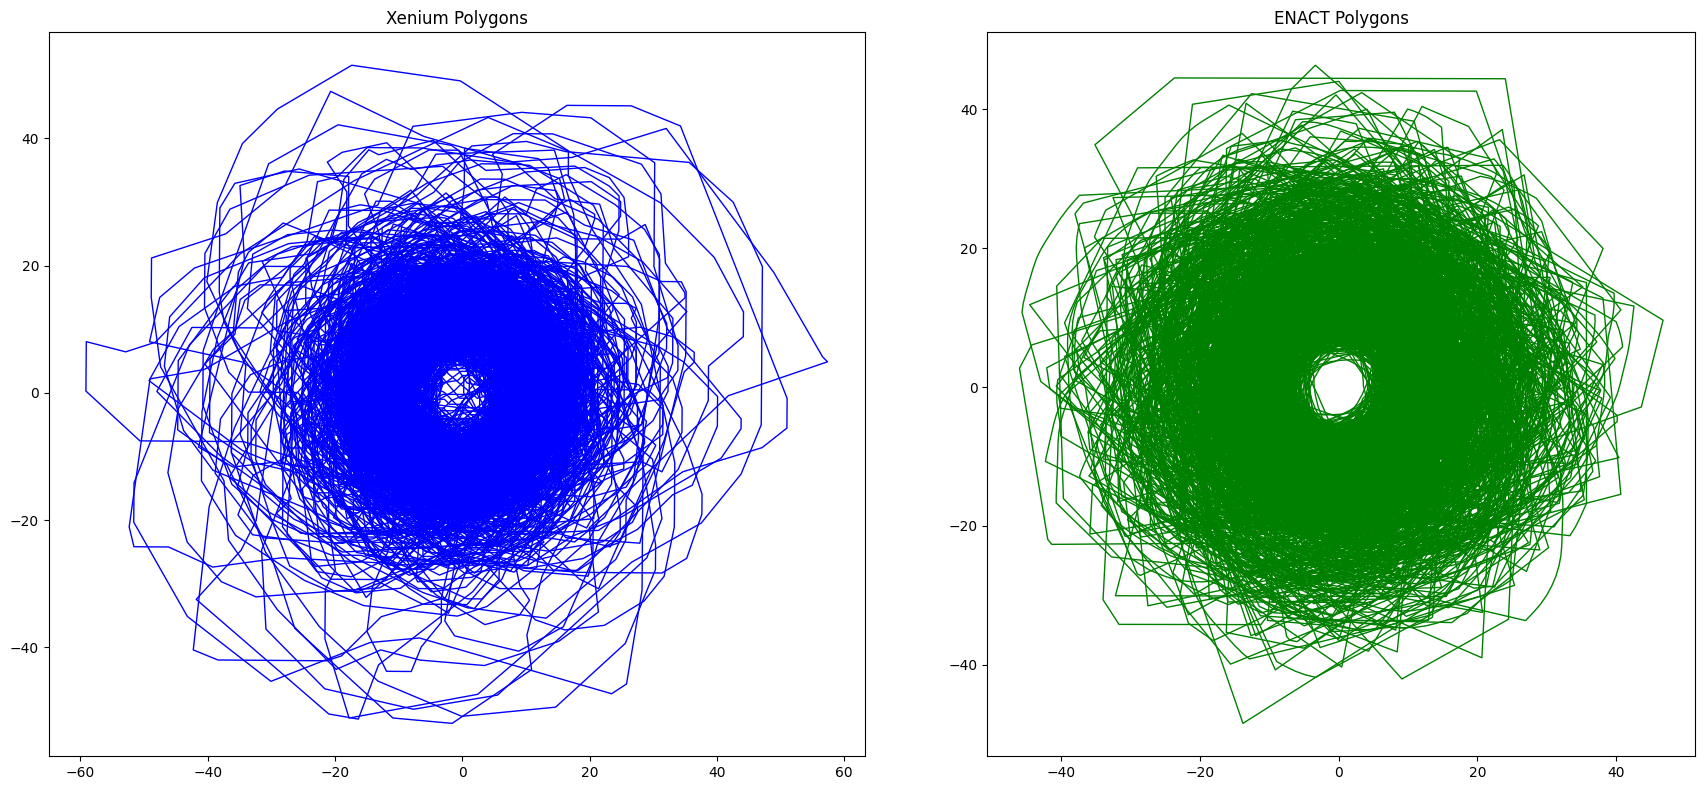

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Xenium polygons
plot_polygons(
    xenium_crop_polygons_demean,
    ax=axs[0],
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)
axs[0].set_title("Xenium Polygons")
axs[0].set_aspect("equal")

# ENACT polygons
plot_polygons(
    enact_crop_polygons_demean,
    ax=axs[1],
    facecolor=(0, 0, 0, 0),
    edgecolor="green",
    linewidth=1,
)
axs[1].set_title("ENACT Polygons")
axs[1].set_aspect("equal")

plt.tight_layout()
plt.show()

In [18]:

xenium_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in xenium_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]



enact_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in enact_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]


In [22]:
xenium_polygons = [poly.reshape(-1, 2) for poly in xenium_polygons]
enact_polygons = [poly.reshape(-1, 2) for poly in enact_polygons]

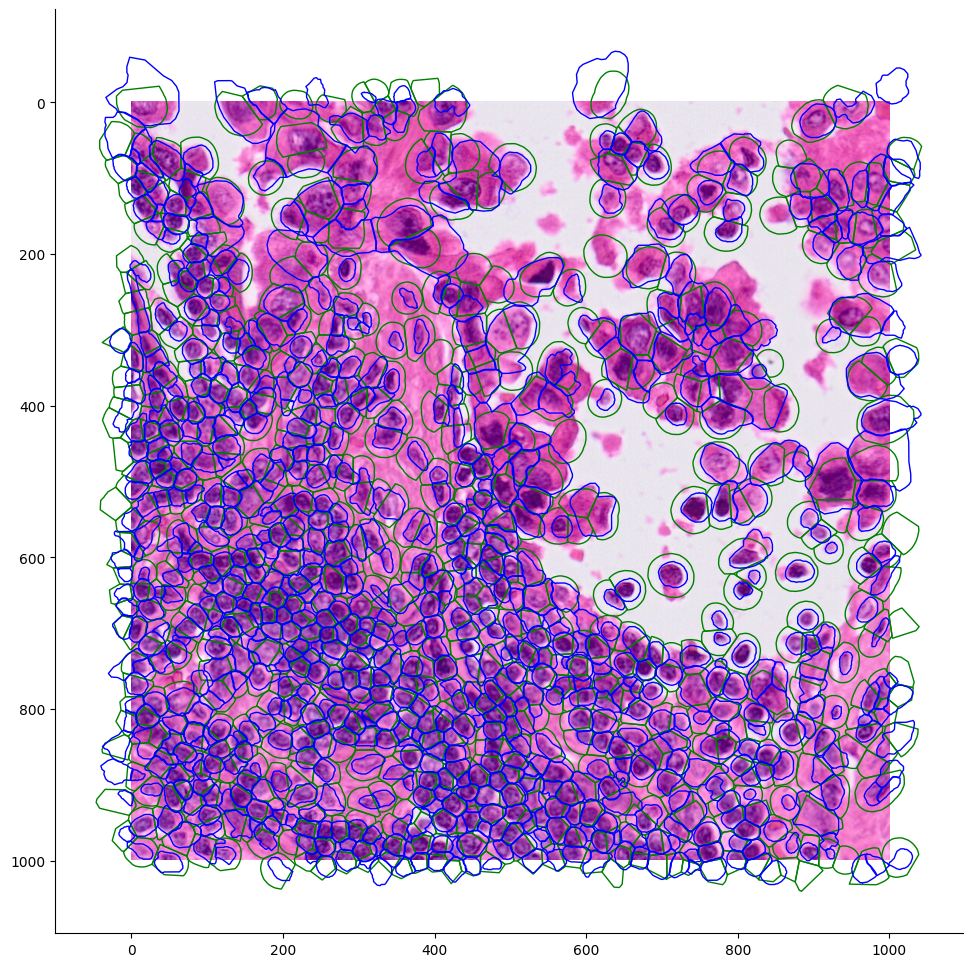

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)
plot_polygons(
    enact_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="green",
    linewidth=1,
)

plot_polygons(
    xenium_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)

# Plot style adjustments
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

In [ ]:
# Add this as a new cell

def compute_iou(poly1, poly2):
    """Compute IoU between two shapely polygons."""
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

def compute_dice(poly1, poly2):
    """Compute Dice coefficient between two shapely polygons."""
    inter = poly1.intersection(poly2).area
    return 2 * inter / (poly1.area + poly2.area) if (poly1.area + poly2.area) > 0 else 0

# Convert your crop polygons back to shapely for comparison
xenium_crop_shapely = [Polygon(poly) for poly in xenium_crop_polygons]
enact_crop_shapely = [Polygon(poly) for poly in enact_crop_polygons]

# For each ENACT polygon, find the best matching Xenium polygon by IoU
ious = []
dices = []
for enact_poly in enact_crop_shapely:
    best_iou = 0
    best_dice = 0
    for xenium_poly in xenium_crop_shapely:
        iou = compute_iou(enact_poly, xenium_poly)
        dice = compute_dice(enact_poly, xenium_poly)
        if iou > best_iou:
            best_iou = iou
        if dice > best_dice:
            best_dice = dice
    ious.append(best_iou)
    dices.append(best_dice)

print(f"Mean IoU: {np.mean(ious):.3f}")
print(f"Mean Dice: {np.mean(dices):.3f}")

Mean IoU: 0.467
Mean Dice: 0.614


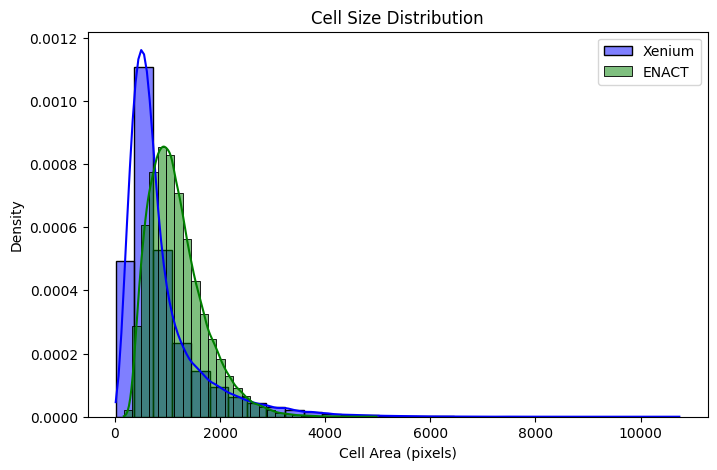

In [25]:
import seaborn as sns

# Calculate areas
xenium_areas = [Polygon(poly).area for poly in xenium_polygons]
enact_areas = [Polygon(poly).area for poly in enact_polygons]

plt.figure(figsize=(8, 5))
sns.histplot(xenium_areas, color="blue", label="Xenium", kde=True, stat="density", bins=30, alpha=0.5)
sns.histplot(enact_areas, color="green", label="ENACT", kde=True, stat="density", bins=30, alpha=0.5)
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Density")
plt.title("Cell Size Distribution")
plt.legend()
plt.show()

In [13]:
from shapely.geometry import Polygon

# Compute areas in pixels for ENACT and Xenium
enact_areas = [Polygon(poly).area for poly in enact_polygons]
xenium_areas = [Polygon(poly).area for poly in xenium_polygons]

# Mean and median in pixels
enact_mean_area_px = np.mean(enact_areas)
enact_median_area_px = np.median(enact_areas)
xenium_mean_area_px = np.mean(xenium_areas)
xenium_median_area_px = np.median(xenium_areas)

print(f"ENACT mean area: {enact_mean_area_px:.2f} px, median area: {enact_median_area_px:.2f} px")
print(f"Xenium mean area: {xenium_mean_area_px:.2f} px, median area: {xenium_median_area_px:.2f} px")

# Conversion to um^2 (replace PIXEL_SIZE_UM with your value)
PIXEL_SIZE_UM = 4.7  # placeholder, update with your pixel size in microns
enact_mean_area_um2 = enact_mean_area_px / (PIXEL_SIZE_UM ** 2)
enact_median_area_um2 = enact_median_area_px / (PIXEL_SIZE_UM ** 2)
xenium_mean_area_um2 = xenium_mean_area_px / (PIXEL_SIZE_UM ** 2)
xenium_median_area_um2 = xenium_median_area_px / (PIXEL_SIZE_UM ** 2)

print(f"ENACT mean area: {enact_mean_area_um2:.2f} um^2, median area: {enact_median_area_um2:.2f} um^2")
print(f"Xenium mean area: {xenium_mean_area_um2:.2f} um^2, median area: {xenium_median_area_um2:.2f} um^2")

ENACT mean area: 1178.81 px, median area: 1080.04 px
Xenium mean area: 898.00 px, median area: 653.62 px
ENACT mean area: 53.36 um^2, median area: 48.89 um^2
Xenium mean area: 40.65 um^2, median area: 29.59 um^2


In [14]:
from shapely.ops import unary_union

# Combine all polygons into one for each segmentation
xenium_union = unary_union([Polygon(poly) for poly in xenium_polygons])
enact_union = unary_union([Polygon(poly) for poly in enact_polygons])

# Compute IoU and Dice for the combined segmentation
combined_iou = compute_iou(xenium_union, enact_union)
print(f"Combined IoU (all cells): {combined_iou:.3f}")

combined_dice = compute_dice(xenium_union, enact_union)
print(f"Combined Dice (all cells): {combined_dice:.3f}")

Combined IoU (all cells): 0.581
Combined Dice (all cells): 0.735


In [15]:
# Define the crop as a polygon
crop_poly = Polygon([
    (0, 0),
    (crop_size, 0),
    (crop_size, crop_size),
    (0, crop_size)
])

full_poly = Polygon([
    (0,139),
    (1845, 139),
    (18456, 24480),
    (0, 24480)
])

# Fraction of crop covered by each segmentation
xenium_frac = xenium_union.area / full_poly.area
enact_frac = enact_union.area / full_poly.area

print(f"Xenium: {xenium_frac:.3%} of crop area covered")
print(f"ENACT: {enact_frac:.3%} of crop area covered")

Xenium: 60.013% of crop area covered
ENACT: 90.516% of crop area covered
